In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
while 'notebooks' in os.getcwd():
    os.chdir('..')

import logging
dataset_name = 'ogbn-arxiv'
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename=f'logs/omega_function/{dataset_name}/11-1-structural_graph_sage_sensitivity_labels.log'
)

In [3]:
import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.data.gamma.structural_arxiv import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.structural_omega.graph_sage import StructuralOmegaGraphSageCosSim

In [4]:
torch.cuda.is_available()

True

In [5]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [37]:
dataset = load_dataset()

In [38]:
data = dataset[0].to(device)
edge_index = data.edge_index

In [39]:
data = prepare_adjencency(data)

## Split by year

In [41]:
year_map = dict(
    zip(range(data.num_nodes), data.node_year.cpu().numpy().squeeze())
)

In [42]:
edge_df_index = pd.MultiIndex.from_arrays(
    edge_index.cpu().numpy(), names=["i", "j"]
)
edge_df = pd.DataFrame(index=edge_df_index)
edge_df["year_i"] = edge_df.index.get_level_values("i").map(year_map)
edge_df["year_j"] = edge_df.index.get_level_values("j").map(year_map)
edge_df["max_year"] = edge_df[["year_i", "year_j"]].max(axis=1)
edge_df

year_i  year_j  max_year
i      j                               
104447 13091     2011    2008      2011
15858  47283     2014    2007      2014
107156 69161     2013    2014      2014
       136440    2013    2013      2013
       107366    2013    2011      2013
...               ...     ...       ...
45118  79124     2020    2015      2020
       147994    2020    2014      2020
       162473    2020    2016      2020
       162537    2020    2014      2020
       72717     2020    2018      2020

[1166243 rows x 3 columns]

In [43]:
def get_train_val_test_edges(edge_index, edges_df, threshold_year: int):
    train_mask = edges_df["max_year"] < threshold_year
    validation_mask = edges_df["max_year"] == threshold_year
    test_mask = edges_df["max_year"] > threshold_year

    edges_train = edge_index[:, train_mask.values]
    edges_val = edge_index[:, validation_mask.values]
    edges_test = edge_index[:, test_mask.values]
    return edges_train, edges_val, edges_test

In [44]:
edges_train, edges_val, edges_test = get_train_val_test_edges(edge_index, edge_df, 2010)
print(f'Train edges: {edges_train.shape[1]}')
print(f'Validation edges: {edges_val.shape[1]}')
print(f'Test edges: {edges_test.shape[1]}')

Train edges: 13749
Validation edges: 7341
Test edges: 1145153


In [40]:
edges_per_threshold = pd.DataFrame(
    columns=["Train", "Validation", "Test"],
    index=pd.Index([], name="$t$"),
)
nodes_per_threshold = pd.DataFrame(
    columns=["Train", "Validation", "Test"],
    index=pd.Index([], name="$t$"),
)
year_series = pd.Series(year_map)
for year in range(2009, 2020):
    edges_train, edges_val, edges_test = get_train_val_test_edges(
        edge_index, edge_df, year
    )
    nodes_train = (year_series < year).sum()
    nodes_val = (year_series == year).sum()
    nodes_test = (year_series > year).sum()
    edges_per_threshold.loc[year] = [
        edges_train.shape[1],
        edges_val.shape[1],
        edges_test.shape[1],
    ]
    nodes_per_threshold.loc[year] = [nodes_train, nodes_val, nodes_test]

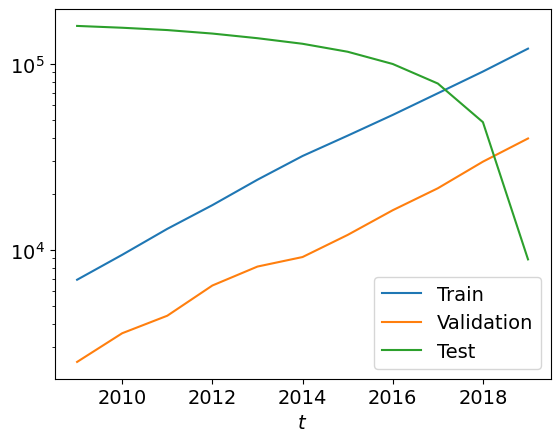

In [41]:
nodes_per_threshold.plot()
plt.yscale("log")

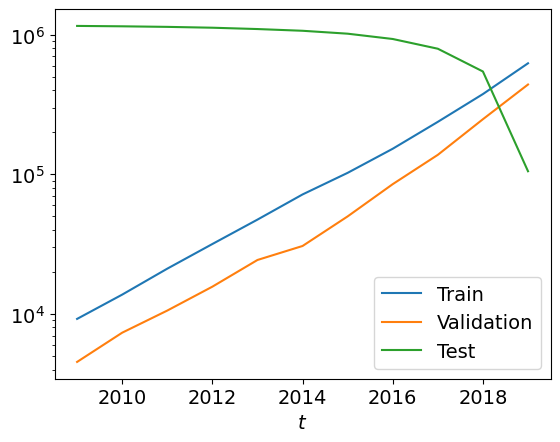

In [42]:
edges_per_threshold.plot()
plt.yscale("log")

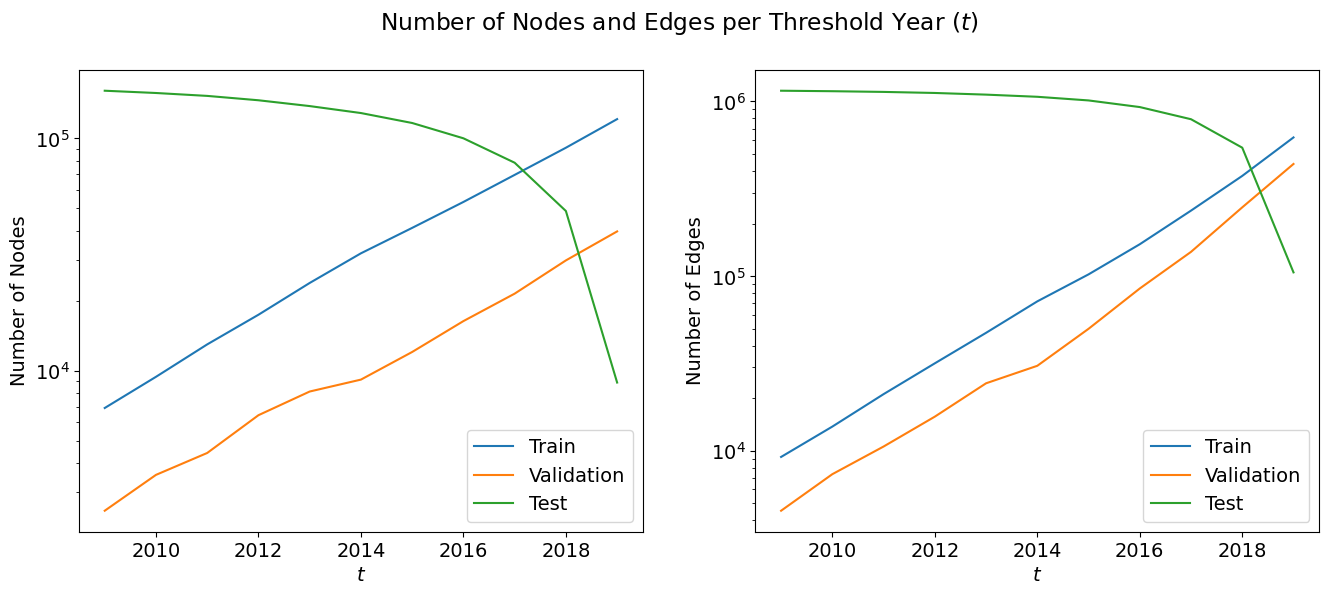

In [45]:
plt.rcParams['font.size'] = '14'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Number of Nodes and Edges per Threshold Year ($t$)")

nodes_per_threshold.plot(ax=ax1)
ax1.set_yscale("log")
ax1.set_ylabel("Number of Nodes")

edges_per_threshold.plot(ax=ax2)
ax2.set_yscale("log")
ax2.set_ylabel("Number of Edges")

plt.savefig(f'reports/images/number_of_edges_and_nodes_per_threshold_year.pdf')

In [46]:
nodes_per_threshold

,Train,Validation,Test
$t$,,,
2009,6911,2499,159933
2010,9410,3564,156369
2011,12974,4427,151942
2012,17401,6435,145507
2013,23836,8135,137372
2014,31971,9154,128218
2015,41125,12035,116183
2016,53160,16339,99844
2017,69499,21442,78402


In [47]:
edges_per_threshold

,Train,Validation,Test
$t$,,,
2009,9215,4534,1152494
2010,13749,7341,1145153
2011,21090,10571,1134582
2012,31661,15674,1118908
2013,47335,24334,1094574
2014,71669,30647,1063927
2015,102316,49910,1014017
2016,152226,84937,929080
2017,237163,137676,791404


## Training

In [6]:
n_layers_graph_sage = 1
# run = 2009 the run will be the threshold year

In [13]:
for year in range(2009, 2020):
    edges_train, edges_val, edges_test = get_train_val_test_edges(
        edge_index, edge_df, year
    )
    omega = StructuralOmegaGraphSageCosSim(
        device,
        dataset="ogbn-arxiv",
        n_layers_graph_sage=n_layers_graph_sage,
        run=year,
        epochs=2000,
        eval_steps=10,
    )
    torch.cuda.empty_cache()
    omega.train(edges_train, edges_val, edges_test, data.x, data.y, data.adj_t)

## Results

### For a Layer Number

In [7]:
metrics = StructuralOmegaGraphSageCosSim.read_metrics(
    n_layers_graph_sage=n_layers_graph_sage, dataset="ogbn-arxiv"
).query('run > 2000')
print(metrics.shape)
metrics.head()

(2211, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
255,2009,0,0.569364,0.553153,0.650903,0.603859,0.636798,0.577466
256,2009,10,0.542549,0.529912,0.632238,0.743863,0.764618,0.614202
257,2009,20,0.513340,0.514963,0.626196,0.814635,0.785367,0.624744
258,2009,30,0.490566,0.505629,0.625522,0.849583,0.788629,0.623993
259,2009,40,0.471926,0.499039,0.625697,0.870160,0.787685,0.628059


In [8]:
def get_best_model_row(year_df):
    return year_df.sort_values('auc_val', ascending=False).iloc[0].drop('run')

best_models = metrics.groupby('run').apply(get_best_model_row).rename_axis('threshold_year')
best_models

,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
threshold_year,,,,,,,
2009,30.0,0.490566,0.505629,0.625522,0.849583,0.788629,0.623993
2010,690.0,0.274721,0.477067,0.716782,0.955551,0.780667,0.616176
2011,530.0,0.333978,0.522027,0.688758,0.923515,0.773187,0.612029
2012,540.0,0.366556,0.536586,0.655466,0.901761,0.747309,0.623701
2013,1170.0,0.369389,0.547651,0.667593,0.892089,0.731915,0.625636
2014,1850.0,0.394601,0.566015,0.670079,0.871491,0.734897,0.636899
2015,860.0,0.435427,0.536401,0.612351,0.845436,0.755138,0.683205
2016,1250.0,0.445544,0.512826,0.581350,0.838006,0.784688,0.730580
2017,930.0,0.461335,0.504387,0.554922,0.829277,0.803257,0.759650


<AxesSubplot: xlabel='threshold_year'>

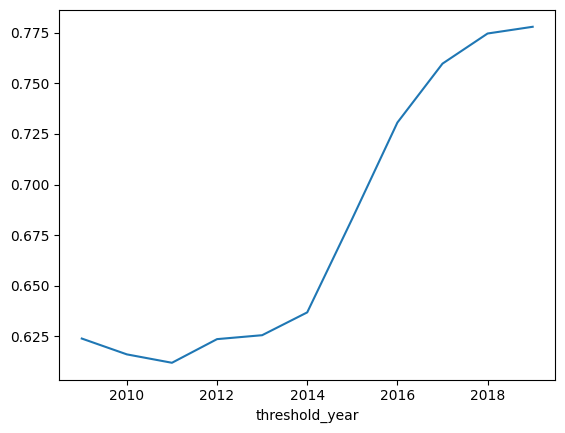

In [9]:
best_models['auc_test'].plot()

## Comparing with $\Omega_p^{1-\textrm{GraphSage}}$

In [48]:
positional_path = f"data/results/{dataset_name}/positional_graph_sage/1layers_sensitivity_aucs.parquet"
positional_auc_df = pd.read_parquet(positional_path)

In [50]:
positional_test_auc_dict = {}
for year in range(2009, 2020):
    year_df = positional_auc_df.query(f'year == {year}')
    max_val_row = year_df.sort_values('train_val_auc', ascending=False).iloc[0]
    train_val_auc, val_auc, test_auc = max_val_row.values
    positional_test_auc_dict[year] = test_auc

In [72]:
positional_test_auc_dict[2015]

0.6892442970269241

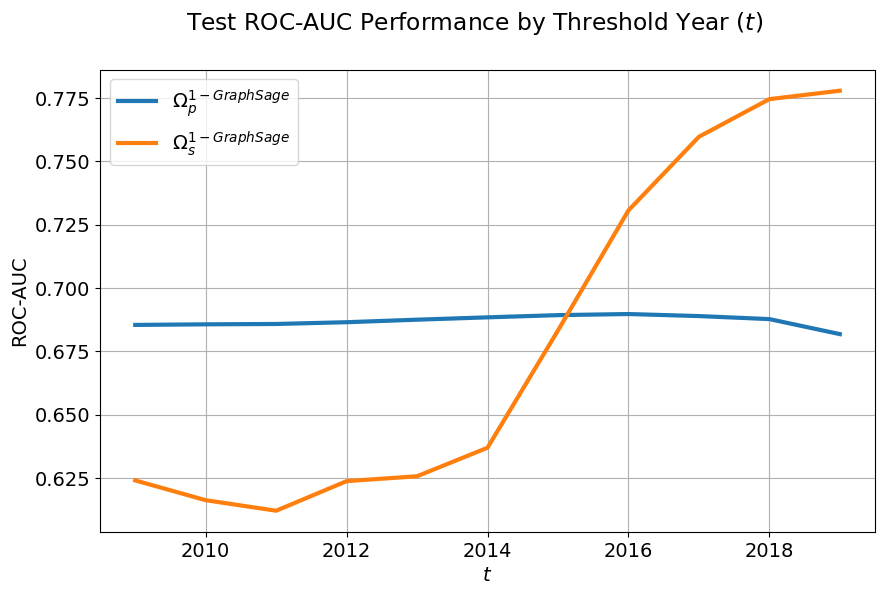

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle("Test ROC-AUC Performance by Threshold Year ($t$)")

lw=3

pd.Series(positional_test_auc_dict).plot(
    ax=ax,
    label="$\Omega_p^{1-GraphSage}$",
    lw=lw,
)
best_models["auc_test"].plot(
    ax=ax,
    label="$\Omega_s^{1-GraphSage}$",
    lw=lw,
)

ax.set_ylabel("ROC-AUC")
ax.set_xlabel("$t$")
ax.grid(zorder=2)
plt.legend()

plt.savefig(f"reports/images/positional_structural_sensitivity_perfomance.pdf")

## Ensemble for $t=2015$

### Positional predictions

In [20]:
n_layers = 1
dataset_name = 'ogbn-arxiv'
t = 2015

#### Getting chosen epoch

In [13]:
output_path = f"data/results/{dataset_name}/positional_graph_sage/{n_layers}layers_sensitivity_aucs.parquet"

In [15]:
positional_aucs_df = pd.read_parquet(output_path)
positional_aucs_df.head()

train_val_auc   val_auc  test_auc
epoch year                                   
1     2009       0.556878  0.544989  0.542157
      2010       0.564802  0.578818  0.542690
      2011       0.567295  0.578977  0.543009
      2012       0.570445  0.580087  0.543334
      2013       0.567192  0.561868  0.544527

In [22]:
positional_epoch = (
    positional_aucs_df.query(f"year == {t}")
    .droplevel("year")["val_auc"]
    .idxmax()
)
positional_epoch

48

In [23]:
positional_aucs_df.loc[(positional_epoch, t)]

train_val_auc    0.649926
val_auc          0.669768
test_auc         0.689522
Name: (48, 2015), dtype: float64

#### Getting predictions

In [24]:
data_path_pat = f"data/scored_omega/{dataset_name}/positional_graph_sage_all_epochs/{n_layers}layers_epoch_{positional_epoch:03d}.parquet"
data_path_pat

'data/scored_omega/ogbn-arxiv/positional_graph_sage_all_epochs/1layers_epoch_048.parquet'

In [57]:
positional_preds = pd.read_parquet(data_path_pat).rename(
    columns={"pred": "positional_pred"}
)
positional_preds.head()

positional_pred
104447 13091          0.707728
15858  47283          0.600977
107156 69161          0.534724
       136440         0.726247
       107366         0.713375

### Structural predictions

In [34]:
structural_epoch = int(best_models.loc[t]['epoch'])
structural_epoch

860

In [35]:
structural_model = StructuralOmegaGraphSageCosSim.load_model(
    device=device,
    dataset="ogbn-arxiv",
    n_layers_graph_sage=n_layers_graph_sage,
    run=t,
    epoch=structural_epoch,
)

In [45]:
edges_train, edges_val, edges_test = get_train_val_test_edges(
    edge_index, edge_df, t
)

In [48]:
preds = structural_model.forward(edges_test, data.x, data.adj_t)
preds = preds.detach().cpu().numpy()
preds[:5]

array([[0.5909227 ],
       [0.64900506],
       [0.6032943 ],
       [0.644334  ],
       [0.7816249 ]], dtype=float32)

In [51]:
edges_test.detach().cpu().numpy()[:, :5]

array([[105794,  21184,  82079,  62345,  62345],
       [142957,  78407,  87455,  25187, 166777]])

In [58]:
index = pd.MultiIndex.from_arrays(
    edges_test.detach().cpu().numpy()
)
structural_preds = pd.DataFrame(preds, index=index, columns=['structural_pred'])
structural_preds.head()

structural_pred
105794 142957         0.590923
21184  78407          0.649005
82079  87455          0.603294
62345  25187          0.644334
       166777         0.781625

### Ensemble

#### Joining data

In [62]:
full_df = structural_preds.merge(
    positional_preds, left_index=True, right_index=True
).rename_axis(['i', 'j'])
full_df.head()

structural_pred  positional_pred
i      j                                       
105794 142957         0.590923         0.705832
21184  78407          0.649005         0.756541
82079  87455          0.603294         0.762574
62345  25187          0.644334         0.754852
       166777         0.781625         0.760878

#### Getting target

In [65]:
full_df["is_same_class"] = (
    data.y.squeeze()[full_df.index.get_level_values("i").values]
    .detach()
    .cpu()
    .numpy()
    == data.y.squeeze()[full_df.index.get_level_values("j").values]
    .detach()
    .cpu()
    .numpy()
).astype(int)
full_df.head()

structural_pred  positional_pred  is_same_class
i      j                                                      
105794 142957         0.590923         0.705832              0
21184  78407          0.649005         0.756541              1
82079  87455          0.603294         0.762574              1
62345  25187          0.644334         0.754852              1
       166777         0.781625         0.760878              1

In [71]:
structural_auc = roc_auc_score(full_df["is_same_class"], full_df["structural_pred"])
structural_auc

0.6832054796217903

In [72]:
positional_auc = roc_auc_score(full_df["is_same_class"], full_df["positional_pred"])
positional_auc

0.6895218468020154

In [73]:
auc_dict = {}
for p in np.linspace(0, 1, 51):
    score = (
        full_df["positional_pred"]
        .mul(p)
        .add(full_df["structural_pred"].mul(1 - p))
    )
    auc = roc_auc_score(full_df["is_same_class"], score)
    auc_dict[p] = auc

In [74]:
auc_df = pd.Series(auc_dict).rename("ROC-AUC").rename_axis("p").to_frame()
auc_df.head()

,ROC-AUC
p,
0.00,0.683205
0.02,0.683670
0.04,0.684148
0.06,0.684638
0.08,0.685141


In [80]:
auc_df.sort_values("ROC-AUC", ascending=False).head()

,ROC-AUC
p,
0.90,0.718663
0.88,0.718588
0.92,0.718159
0.86,0.718142
0.84,0.717453


In [103]:
auc_df.query('`ROC-AUC` > @positional_auc')

,ROC-AUC
p,
0.24,0.689706
0.26,0.690353
0.28,0.691018
0.30,0.691703
0.32,0.692408
0.34,0.693134
0.36,0.693881
0.38,0.694650
0.40,0.695443


In [110]:
rel_diff = auc_df['ROC-AUC'].max()/positional_auc - 1
print(f'Relative difference: {rel_diff:.1%}')

Relative difference: 4.2%


In [112]:
abs_diff = auc_df['ROC-AUC'].max() - positional_auc
print(f'Absolute difference: {abs_diff:.1}')

Absolute difference: 0.03


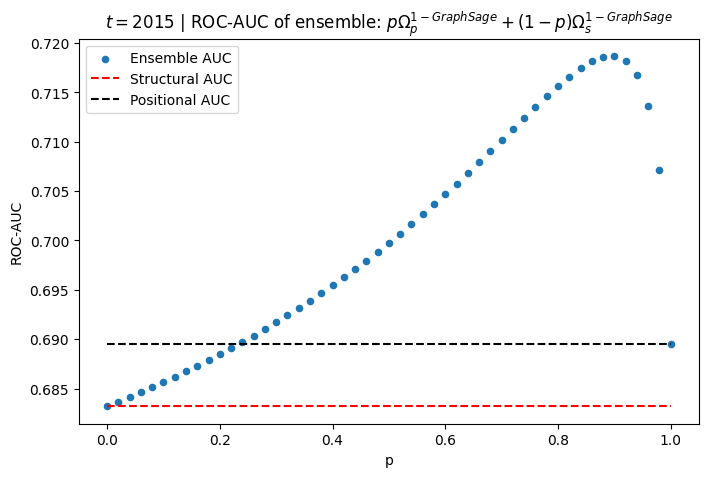

<Figure size 640x480 with 0 Axes>

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

auc_df.reset_index().plot(
    kind="scatter",
    x="p",
    y="ROC-AUC",
    label="Ensemble AUC",
    ax=ax,
)

ax.hlines(
    structural_auc,
    xmin=0,
    xmax=1,
    ls="--",
    color="red",
    label="Structural AUC",
)
ax.hlines(
    positional_auc,
    xmin=0,
    xmax=1,
    ls="--",
    color="black",
    label="Positional AUC",
)

plt.legend()
plt.title(
    "$t=2015$ | ROC-AUC of ensemble: $p\Omega_p^{1-GraphSage} + (1-p)\Omega_s^{1-GraphSage}$"
)
plt.show()

plt.savefig('reports/images/ogbn-arxiv/t=2015_auc_ensemble.pdf')